Francisco José Durá Galiana

# Red simple para predicción de género

In [2]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

import os
import keras
import h5py
import librosa
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard

Using TensorFlow backend.


## Leer datos

In [6]:
# Parámetros de extracción de canciones
gtzan_dir = r"D:\Users\franc\Documents\IMF - Deep Learning\Trabajo Master\Datasets\GTZAN\genres"
data_df = pd.read_csv(r"D:\Users\franc\Documents\IMF - Deep Learning\Trabajo Master\Scripts\gtzan_clean.csv")
song_samples = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

In [9]:
X = np.load('x_db_scaled.npy')
y1 = np.load('y1_gtzan_npy.npy')

convertimos la variable de target a una variable one-hot para poder utilizar en la capa de salida de la red como clasificación categórica

In [10]:
y1 = to_categorical(y1)

## Partición de los datos
A continuación se procede a la partición de los datos en sets de entrenamiento y validación. Originalmente se utilizaba un split de 70/30 de entrenamiento y validación, pero vamos a utilizar un split de entrenamiento/test de 80/20 y utilizaremos un 25% del entrenamiento para validación.

In [13]:
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=42, stratify = y1)

Para comprobar que la distribución de las categorías es equitativa entre los sets pintamos el siguiente gráfico de barras:

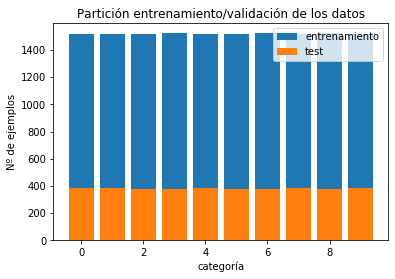

In [16]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y1_train, axis=1), return_counts=True)
plt.bar(values, count, label='entrenamiento')

values, count = np.unique(np.argmax(y1_test, axis=1), return_counts=True)
plt.bar(values, count, label='test')
plt.title('Partición entrenamiento/validación de los datos')
plt.xlabel('categoría')
plt.ylabel('Nº de ejemplos')
plt.legend()
plt.show()

## Construcción del modelo

In [18]:
# Model Definition
class MIR:
    
    def build(num_genres=10):
        input_shape = X_train[0].shape

        inputs = Input(shape=input_shape)
        # Conv Block 1
        x1 = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), activation='relu', name='C1')(inputs)
        x1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='P1')(x1)
        x1 = Dropout(0.25, name='D1')(x1)

        # Conv Block 2
        x2 = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', name='C2')(x1)
        x2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='P2')(x2)
        x2 = Dropout(0.25, name='D2')(x2)

        # Conv Block 3
        x3 = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', name='C3')(x2)
        x3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='P3')(x3)
        x3 = Dropout(0.25, name='D3')(x3)

        # Conv Block 4
        x4 = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', name='C4')(x3)
        x4 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='P4')(x4)
        x4 = Dropout(0.25, name='D4')(x4)

        # Conv Block 5
        x5 = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', name='C5')(x4)
        x5 = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), name='P5')(x5)
        x5 = Dropout(0.25, name='D5')(x5)

        # MLP
        y = Flatten(name='C_out')(x5)
        y1 = Dense(num_genres, activation='softmax', name="genre")(y)

        model = Model(
            inputs=inputs,
            outputs=[y1],
            name="MIR_genre")
        
        return model

In [19]:
model = MIR.build()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 129, 1)       0         
_________________________________________________________________
C1 (Conv2D)                  (None, 126, 127, 16)      160       
_________________________________________________________________
P1 (MaxPooling2D)            (None, 63, 63, 16)        0         
_________________________________________________________________
D1 (Dropout)                 (None, 63, 63, 16)        0         
_________________________________________________________________
C2 (Conv2D)                  (None, 61, 61, 32)        4640      
_________________________________________________________________
P2 (MaxPooling2D)            (None, 30, 30, 32)        0         
_________________________________________________________________
D2 (Dropout)                 (None, 30, 30, 32)        0         
__________

## Entrenamiento del modelo

In [20]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [21]:
tensorboard = TensorBoard(log_dir='./logs/scalars/genre', histogram_freq=0, write_graph=True)

hist = model.fit(X_train, y1_train,
          batch_size=32, # tamaño del batch de entrenamiento
          epochs=200, # Número de pases
          verbose=1, # Mostrar progreso
          validation_split=0.25,
          callbacks=[tensorboard]) # Seleccionar un 25% de los datos para validación 

Train on 11400 samples, validate on 3800 samples
Epoch 1/200
11400/11400 [==============================] - 7s 577us/step - loss: 3.7356 - acc: 0.1918 - val_loss: 1.9610 - val_acc: 0.3013
Epoch 2/200
11400/11400 [==============================] - 5s 469us/step - loss: 1.6669 - acc: 0.4009 - val_loss: 1.9142 - val_acc: 0.3087
Epoch 3/200
11400/11400 [==============================] - 6s 483us/step - loss: 1.4072 - acc: 0.4949 - val_loss: 1.5280 - val_acc: 0.4705
Epoch 4/200
11400/11400 [==============================] - 5s 467us/step - loss: 1.2702 - acc: 0.5468 - val_loss: 1.3330 - val_acc: 0.5571
Epoch 5/200
11400/11400 [==============================] - 5s 461us/step - loss: 1.1879 - acc: 0.5768 - val_loss: 1.2855 - val_acc: 0.5718
Epoch 6/200
11400/11400 [==============================] - 5s 472us/step - loss: 1.1147 - acc: 0.6075 - val_loss: 1.2140 - val_acc: 0.5763
Epoch 7/200
11400/11400 [==============================] - 6s 491us/step - loss: 1.0598 - acc: 0.6317 - val_loss: 1.1

11400/11400 [==============================] - 5s 458us/step - loss: 0.3880 - acc: 0.8635 - val_loss: 0.4823 - val_acc: 0.8445
Epoch 118/200
11400/11400 [==============================] - 5s 458us/step - loss: 0.4006 - acc: 0.8668 - val_loss: 0.4986 - val_acc: 0.8284
Epoch 119/200
11400/11400 [==============================] - 5s 459us/step - loss: 0.3953 - acc: 0.8627 - val_loss: 0.5085 - val_acc: 0.8258
Epoch 120/200
11400/11400 [==============================] - 5s 459us/step - loss: 0.3800 - acc: 0.8708 - val_loss: 0.4166 - val_acc: 0.8555
Epoch 121/200
11400/11400 [==============================] - 5s 458us/step - loss: 0.4019 - acc: 0.8584 - val_loss: 0.5743 - val_acc: 0.8208
Epoch 122/200
11400/11400 [==============================] - 5s 460us/step - loss: 0.3898 - acc: 0.8693 - val_loss: 0.5205 - val_acc: 0.8211
Epoch 123/200
11400/11400 [==============================] - 5s 458us/step - loss: 0.3848 - acc: 0.8727 - val_loss: 0.4918 - val_acc: 0.8329
Epoch 124/200
11400/11400 [

## Resultados

In [22]:
score_test = model.evaluate(X_test, y1_test, verbose=0)
print("\t\t|-----------|-------|")
print("\tGenre\t| Precisión | Coste |")
print("+---------------+-----------+-------+")
print("| Entrenamiento\t|   {:5.3f}   | {:5.2f} |".format(hist.history['acc'][-1], hist.history['loss'][-1]))
print("| Validacion\t|   {:5.3f}   | {:5.2f} |".format(hist.history['val_acc'][-1], hist.history['val_loss'][-1]))
print("| Test\t\t|   {:5.3f}   | {:5.2f} |".format(score_test[1], score_test[0]))
print("+---------------+-----------+-------+")

		|-----------|-------|
	Genre	| Precisión | Coste |
+---------------+-----------+-------+
| Entrenamiento	|   0.885   |  0.34 |
| Validacion	|   0.829   |  0.54 |
| Test		|   0.828   |  0.52 |
+---------------+-----------+-------+


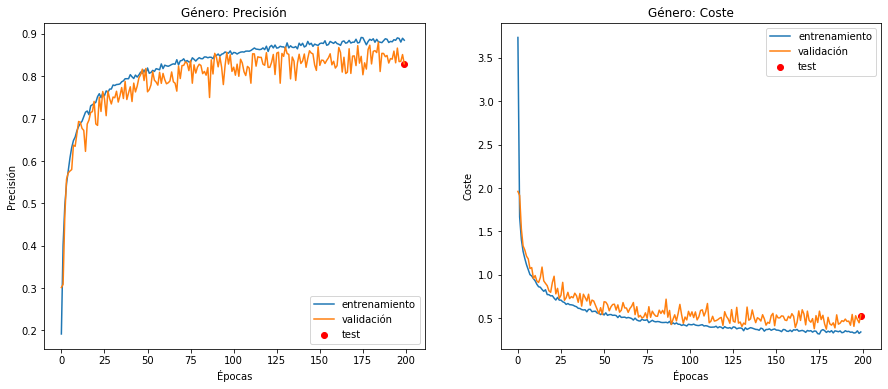

In [23]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(hist.history['acc'], label='entrenamiento')
plt.plot(hist.history['val_acc'], label='validación')
plt.scatter(x=len(hist.history['acc'])-1, y = score_test[1], c='red',label='test')
plt.title('Género: Precisión')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='entrenamiento')
plt.plot(hist.history['val_loss'], label='validación')
plt.scatter(x=len(hist.history['loss'])-1, y = score_test[0], c='red',label='test')
plt.title('Género: Coste')
plt.xlabel('Épocas')
plt.ylabel('Coste')
plt.legend()

In [24]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Si se elige normalize=True los valores de las filas se normalizaran
    if normalize:
        # normalizar sobre las filas (valores verdaderos)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # generar gráfico
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    # Generar ejes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Añadir anotaciones a celdas
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Utilizamos los datos de test para generar la matriz de confusión

In [25]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y1_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

Dibujamos la matriz de confusión con normalización sobre las filas/valores reales:

Normalized confusion matrix


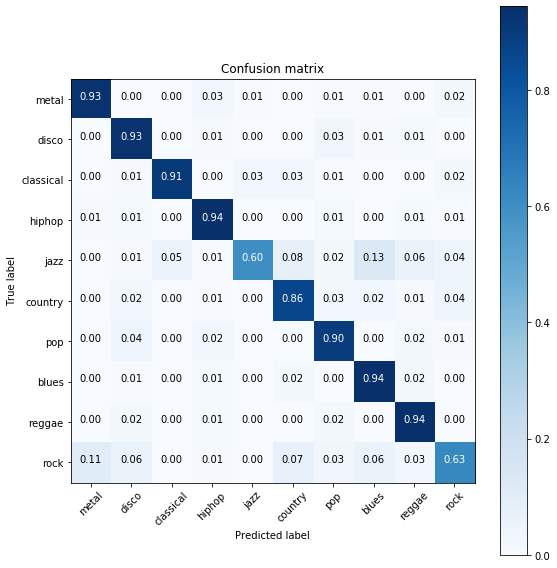

In [26]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys() # extraer nombres de categorías

plt.figure(figsize=(8,8)) 
plot_confusion_matrix(cm, keys, normalize=True)

Los labels True y predicted estan intercambiados (esto se arregla en la memoria)

## Save the model
En el caso de que quisieramos guardar el modelo con sus pesos entrenados para uso futuro podemos utilizar la función `save()`:

In [27]:
# Save the model
# model.save('models/standard_genre.h5')